# Phase 3: Baseline Modeling - TechNova Partners Turnover Analysis

**Objective**: Establish baseline model performance using simple train/test split and fundamental algorithms.

**Models to evaluate**:
1. **Dummy Classifier** (baseline)
2. **Logistic Regression** (linear model)
3. **Random Forest** (non-linear tree model)

**Metrics**: Confusion matrix, precision, recall, F1-score, classification report

---

## 1. Environment Setup & Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# System libraries
from pathlib import Path
import pickle

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
np.random.seed(42)

print("Environment setup complete")

Environment setup complete


In [2]:
# Setup robust path handling and load data
import sys
from pathlib import Path

# Add project root to Python path and setup environment
current_dir = Path.cwd()
project_root = current_dir
while project_root != project_root.parent:
    if (project_root / 'pyproject.toml').exists() or (project_root / 'hr_analytics_utils.py').exists():
        break
    project_root = project_root.parent

sys.path.insert(0, str(project_root))

# Import utilities and setup environment
from hr_analytics_utils import setup_notebook_environment, load_modeling_data_from_db, print_database_status

# Setup environment
env_info = setup_notebook_environment()

# Check database status first
print_database_status()

# Load features and target from database using robust paths
X, y = load_modeling_data_from_db()

if X is None or y is None:
    raise ValueError("Could not load data from database. Please ensure notebook 2 has been executed.")

print(f"\nData loaded successfully:")
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Target distribution: {y.value_counts().to_dict()}")

# Check feature types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nFeature types:")
print(f"   Numeric features: {len(numeric_features)}")
print(f"   Categorical features: {len(categorical_features)}")

# Check for missing values
print(f"\nData quality check:")
print(f"   Missing values in X: {X.isnull().sum().sum()}")
print(f"   Missing values in y: {y.isnull().sum()}")
print(f"   Duplicate rows: {X.duplicated().sum()}")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Project root already in Python path: /workspaces/Automated-classification
NOTEBOOK ENVIRONMENT SETUP
Project root: /workspaces/Automated-classification
Results directory: /workspaces/Automated-classification/results
Database path: /workspaces/Automated-classification/results/technova_hr.db
Python path includes project: True

Data files status:
   OK extrait_sirh.csv: /workspaces/Automated-classification/extrait_sirh.csv
   OK extrait_eval.csv: /workspaces/Automated-classification/extrait_eval.csv
   OK extrait_sondage.csv: /workspaces/Automated-classification/extrait_sondage.csv

Database status: OK /workspaces/Automated-classification/results/technova_hr.db

Environment setup complete!

DATABASE STATUS
Available tables:
   • baseline_feature_importance: 1,551 records
   • baseline_model_results: 3 records
   • baseline_predictions: 294 records
   • employee_data: 1,470 records
   • features: 1,470 records
   • features_X: 1,470 records
   • modeling_data: 1,470 records
   • target: 1,

Data loaded from database:
   Database: /workspaces/Automated-classification/results/technova_hr.db
   Features shape: (1470, 1551)
   Target shape: (1470,)
   Target distribution: {0: 1233, 1: 237}
   Turnover rate: 16.12%

Data loaded successfully:
   Features shape: (1470, 1551)
   Target shape: (1470,)
   Target distribution: {0: 1233, 1: 237}

Feature types:
   Numeric features: 1551
   Categorical features: 0

Data quality check:
   Missing values in X: 0
   Missing values in y: 0
   Duplicate rows: 0


## 2. Data Splitting & Preprocessing

In [3]:
# Split data into train and test sets
print(" Splitting data into train/test sets:")
print("=" * 40)

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Data split completed:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Features: {X_train.shape[1]}")

# Check class distribution in both sets
print(f"\nClass distribution:")
print(f"   Training - Stay: {(y_train == 0).sum()}, Leave: {(y_train == 1).sum()}")
print(f"   Test - Stay: {(y_test == 0).sum()}, Leave: {(y_test == 1).sum()}")
print(f"   Training turnover rate: {y_train.mean():.2%}")
print(f"   Test turnover rate: {y_test.mean():.2%}")

 Splitting data into train/test sets:
Data split completed:
   Training set: 1176 samples
   Test set: 294 samples
   Features: 1551

Class distribution:
   Training - Stay: 986, Leave: 190
   Test - Stay: 247, Leave: 47
   Training turnover rate: 16.16%
   Test turnover rate: 15.99%


In [4]:
# Preprocessing - handle categorical variables and scaling
print("Preprocessing data:")
print("=" * 20)

# Separate numerical and categorical features
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Handle categorical variables with one-hot encoding if any exist
if categorical_features:
    print("\n📝 Encoding categorical variables...")
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
    
    # Align columns between train and test sets
    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)
else:
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

print(f"\nPreprocessing complete:")
print(f"   Final feature count: {X_train_encoded.shape[1]}")
print(f"   Training set shape: {X_train_encoded.shape}")
print(f"   Test set shape: {X_test_encoded.shape}")

# Store processed data
X_train_final = X_train_encoded
X_test_final = X_test_encoded

Preprocessing data:
Numerical features: 1551
Categorical features: 0

Preprocessing complete:
   Final feature count: 1551
   Training set shape: (1176, 1551)
   Test set shape: (294, 1551)


## 3. Baseline Models

In [5]:
# 1. Dummy Classifier (Baseline)
print("Dummy Classifier (Baseline):")
print("=" * 35)

# Create dummy classifier with different strategies
dummy_strategies = ['most_frequent', 'prior', 'stratified']
dummy_results = {}

for strategy in dummy_strategies:
    dummy_clf = DummyClassifier(strategy=strategy, random_state=42)
    dummy_clf.fit(X_train_final, y_train)
    dummy_pred = dummy_clf.predict(X_test_final)
    
    # Calculate metrics
    precision = precision_score(y_test, dummy_pred, average='binary')
    recall = recall_score(y_test, dummy_pred, average='binary')
    f1 = f1_score(y_test, dummy_pred, average='binary')
    
    dummy_results[strategy] = {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"\n{strategy.capitalize()} strategy:")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-score: {f1:.4f}")

# Use the best dummy classifier as baseline
best_dummy_strategy = max(dummy_results, key=lambda x: dummy_results[x]['f1'])
dummy_baseline = DummyClassifier(strategy=best_dummy_strategy, random_state=42)
dummy_baseline.fit(X_train_final, y_train)
dummy_pred = dummy_baseline.predict(X_test_final)

print(f"\nBest dummy strategy: {best_dummy_strategy}")
print(f"   This will be our baseline to beat.")

Dummy Classifier (Baseline):

Most_frequent strategy:
   Precision: 0.0000
   Recall: 0.0000
   F1-score: 0.0000

Prior strategy:
   Precision: 0.0000
   Recall: 0.0000
   F1-score: 0.0000



Stratified strategy:
   Precision: 0.1224
   Recall: 0.1277
   F1-score: 0.1250

Best dummy strategy: stratified
   This will be our baseline to beat.


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [6]:
# 2. Logistic Regression (Linear Model)
print("Logistic Regression:")
print("=" * 25)

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

# Create and train logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Make predictions
log_reg_pred = log_reg.predict(X_test_scaled)
log_reg_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
log_reg_precision = precision_score(y_test, log_reg_pred)
log_reg_recall = recall_score(y_test, log_reg_pred)
log_reg_f1 = f1_score(y_test, log_reg_pred)
log_reg_auc = roc_auc_score(y_test, log_reg_pred_proba)

print(f"\nLogistic Regression Results:")
print(f"   Precision: {log_reg_precision:.4f}")
print(f"   Recall: {log_reg_recall:.4f}")
print(f"   F1-score: {log_reg_f1:.4f}")
print(f"   AUC-ROC: {log_reg_auc:.4f}")

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': X_train_final.columns,
    'coefficient': log_reg.coef_[0],
    'abs_coefficient': np.abs(log_reg.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 10 most important features (by coefficient magnitude):")
for i, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']:<30} {row['coefficient']:>8.4f}")

Logistic Regression:



Logistic Regression Results:
   Precision: 1.0000
   Recall: 0.1064
   F1-score: 0.1923
   AUC-ROC: 0.8147

Top 10 most important features (by coefficient magnitude):
   heure_supplementaires_Oui        0.4382
   heure_supplementaires_binary     0.4382
   eval_number_E_1869               0.3627
   eval_number_E_1821               0.3544
   eval_number_E_1295               0.3418
   eval_number_E_1038               0.3353
   eval_number_E_1127               0.3333
   eval_number_E_840                0.3303
   eval_number_E_825                0.3296
   nombre_experiences_precedentes   0.3292


In [7]:
# 3. Random Forest (Non-linear Tree Model)
print("Random Forest:")
print("=" * 17)

# Create and train random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_final, y_train)

# Make predictions
rf_pred = rf.predict(X_test_final)
rf_pred_proba = rf.predict_proba(X_test_final)[:, 1]

# Calculate metrics
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"\nRandom Forest Results:")
print(f"   Precision: {rf_precision:.4f}")
print(f"   Recall: {rf_recall:.4f}")
print(f"   F1-score: {rf_f1:.4f}")
print(f"   AUC-ROC: {rf_auc:.4f}")

# Feature importance
rf_feature_importance = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features (by Random Forest importance):")
for i, row in rf_feature_importance.head(10).iterrows():
    print(f"   {row['feature']:<30} {row['importance']:>8.4f}")

Random Forest:



Random Forest Results:
   Precision: 0.5000
   Recall: 0.0851
   F1-score: 0.1455
   AUC-ROC: 0.8024

Top 10 most important features (by Random Forest importance):
   age                              0.0349
   salary_per_experience            0.0338
   annee_experience_totale          0.0307
   training_per_year                0.0299
   distance_domicile_travail        0.0296
   annees_dans_l_entreprise         0.0280
   satisfaction_mean                0.0260
   satisfaction_std                 0.0246
   nombre_experiences_precedentes   0.0228
   years_in_position_ratio          0.0220


## 4. Model Comparison & Evaluation

 Model Comparison:
              Model  Precision  Recall  F1-Score  AUC-ROC
   Dummy (Baseline)     0.1224  0.1277    0.1250   0.5000
Logistic Regression     1.0000  0.1064    0.1923   0.8147
      Random Forest     0.5000  0.0851    0.1455   0.8024


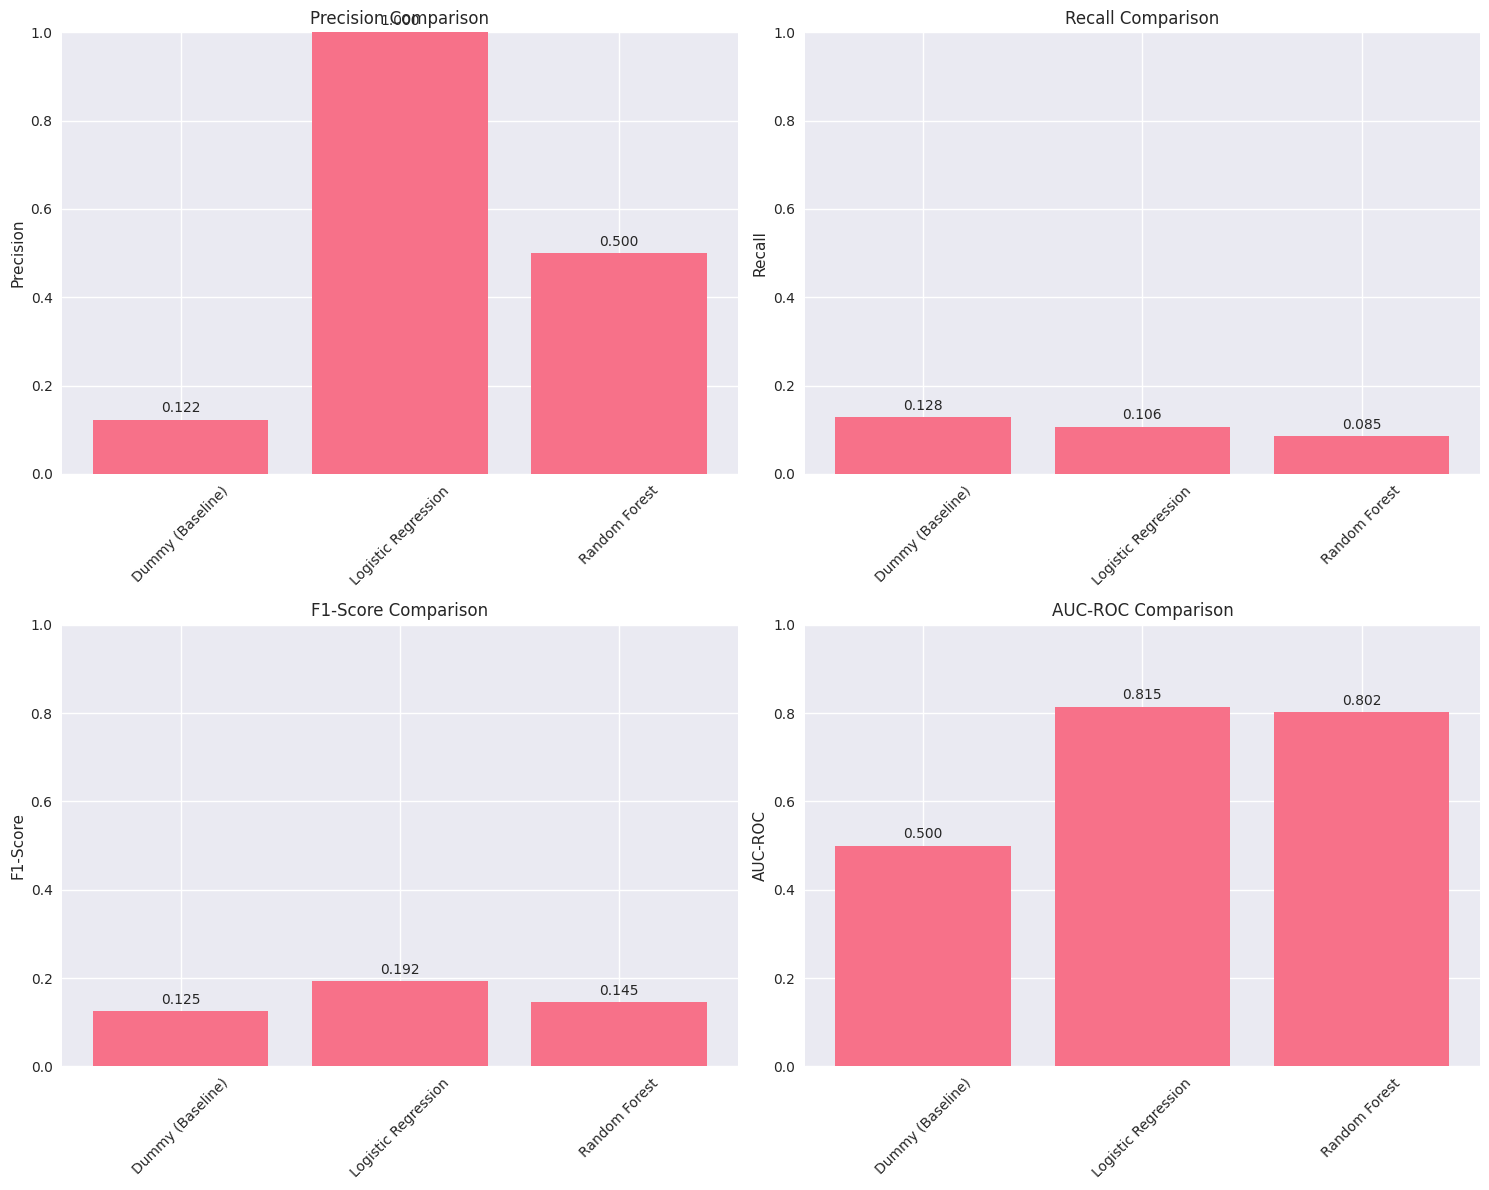

In [8]:
# Compare all models
print(" Model Comparison:")
print("=" * 20)

# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Dummy (Baseline)', 'Logistic Regression', 'Random Forest'],
    'Precision': [
        dummy_results[best_dummy_strategy]['precision'],
        log_reg_precision,
        rf_precision
    ],
    'Recall': [
        dummy_results[best_dummy_strategy]['recall'],
        log_reg_recall,
        rf_recall
    ],
    'F1-Score': [
        dummy_results[best_dummy_strategy]['f1'],
        log_reg_f1,
        rf_f1
    ],
    'AUC-ROC': [
        0.5,  # Dummy classifier AUC is 0.5
        log_reg_auc,
        rf_auc
    ]
})

print(results_df.to_string(index=False, float_format='%.4f'))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC']
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(results_df['Model'], results_df[metric])
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Confusion Matrices:


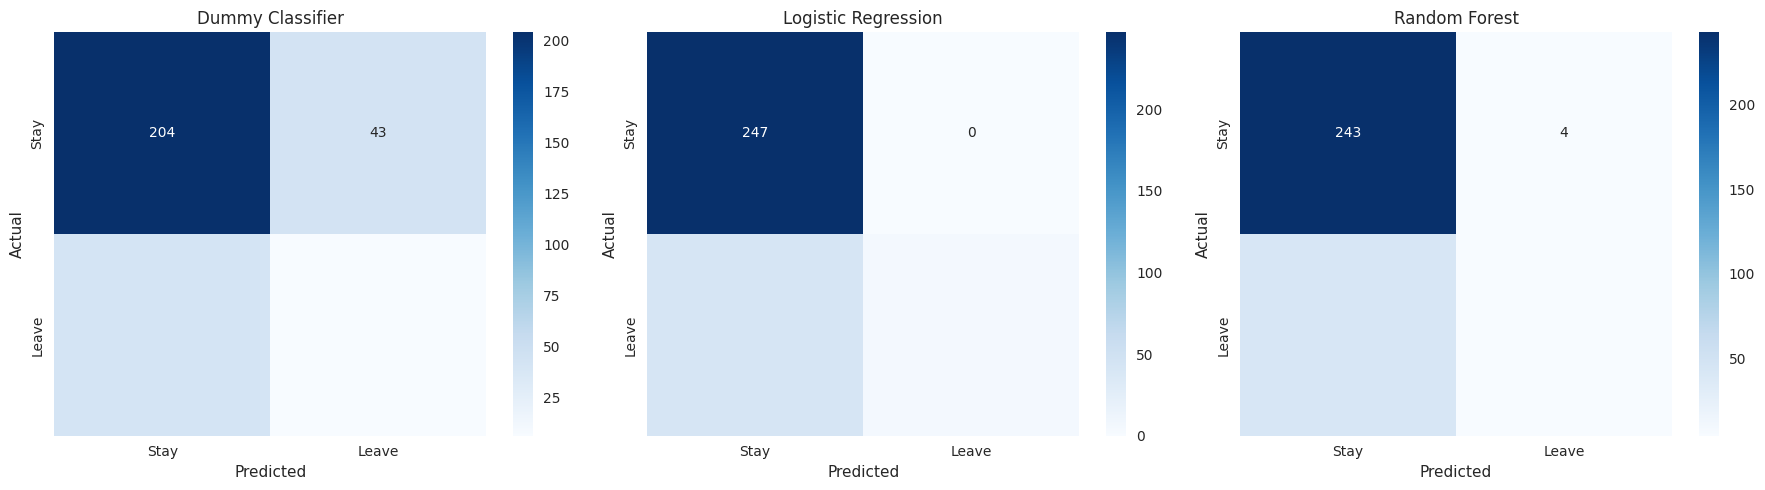


Dummy:
  True Negatives (Stay correctly predicted): 204
  False Positives (Stay predicted as Leave): 43
  False Negatives (Leave predicted as Stay): 41
  True Positives (Leave correctly predicted): 6
  Accuracy: 0.7143

Logistic Regression:
  True Negatives (Stay correctly predicted): 247
  False Positives (Stay predicted as Leave): 0
  False Negatives (Leave predicted as Stay): 42
  True Positives (Leave correctly predicted): 5
  Accuracy: 0.8571

Random Forest:
  True Negatives (Stay correctly predicted): 243
  False Positives (Stay predicted as Leave): 4
  False Negatives (Leave predicted as Stay): 43
  True Positives (Leave correctly predicted): 4
  Accuracy: 0.8401


In [9]:
# Confusion matrices for all models
print("Confusion Matrices:")
print("=" * 22)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dummy classifier confusion matrix
dummy_cm = confusion_matrix(y_test, dummy_pred)
sns.heatmap(dummy_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Dummy Classifier')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Stay', 'Leave'])
axes[0].set_yticklabels(['Stay', 'Leave'])

# Logistic regression confusion matrix
log_reg_cm = confusion_matrix(y_test, log_reg_pred)
sns.heatmap(log_reg_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Logistic Regression')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Stay', 'Leave'])
axes[1].set_yticklabels(['Stay', 'Leave'])

# Random forest confusion matrix
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Random Forest')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticklabels(['Stay', 'Leave'])
axes[2].set_yticklabels(['Stay', 'Leave'])

plt.tight_layout()
plt.show()

# Print detailed confusion matrix statistics
models = ['Dummy', 'Logistic Regression', 'Random Forest']
cms = [dummy_cm, log_reg_cm, rf_cm]

for model, cm in zip(models, cms):
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{model}:")
    print(f"  True Negatives (Stay correctly predicted): {tn}")
    print(f"  False Positives (Stay predicted as Leave): {fp}")
    print(f"  False Negatives (Leave predicted as Stay): {fn}")
    print(f"  True Positives (Leave correctly predicted): {tp}")
    print(f"  Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")

In [10]:
# Detailed classification reports
print("Classification Reports:")
print("=" * 27)

models = ['Dummy Classifier', 'Logistic Regression', 'Random Forest']
predictions = [dummy_pred, log_reg_pred, rf_pred]

for model, pred in zip(models, predictions):
    print(f"\n{model}:")
    print("="*50)
    print(classification_report(y_test, pred, target_names=['Stay', 'Leave']))

Classification Reports:

Dummy Classifier:
              precision    recall  f1-score   support

        Stay       0.83      0.83      0.83       247
       Leave       0.12      0.13      0.12        47

    accuracy                           0.71       294
   macro avg       0.48      0.48      0.48       294
weighted avg       0.72      0.71      0.72       294


Logistic Regression:
              precision    recall  f1-score   support

        Stay       0.85      1.00      0.92       247
       Leave       1.00      0.11      0.19        47

    accuracy                           0.86       294
   macro avg       0.93      0.55      0.56       294
weighted avg       0.88      0.86      0.81       294


Random Forest:
              precision    recall  f1-score   support

        Stay       0.85      0.98      0.91       247
       Leave       0.50      0.09      0.15        47

    accuracy                           0.84       294
   macro avg       0.67      0.53      0.53    

ROC Curves:


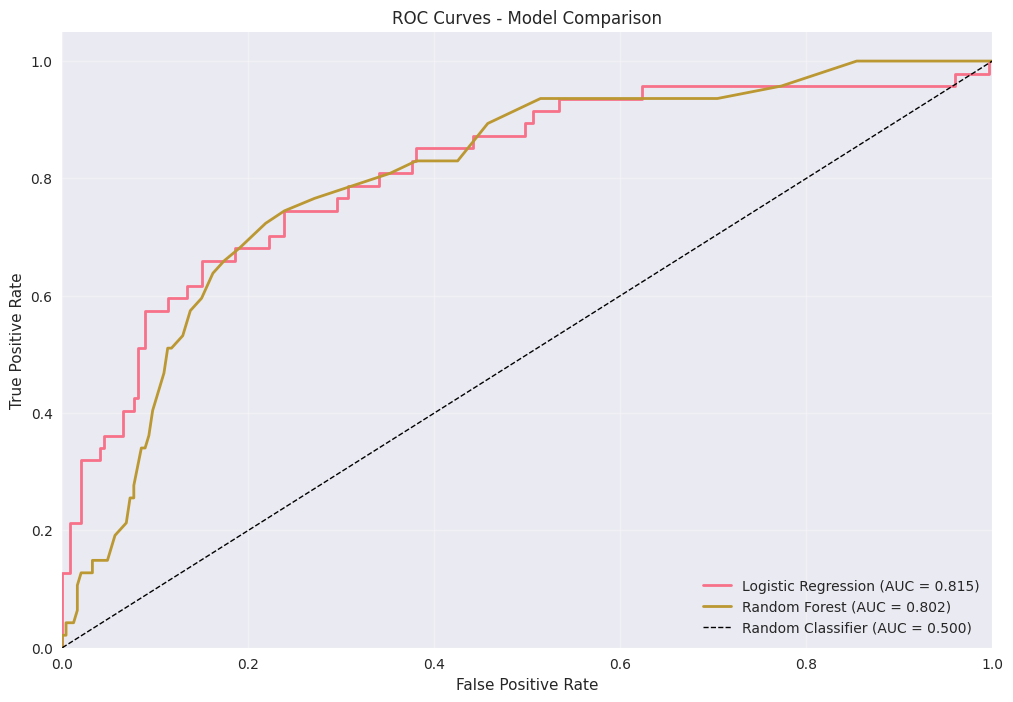

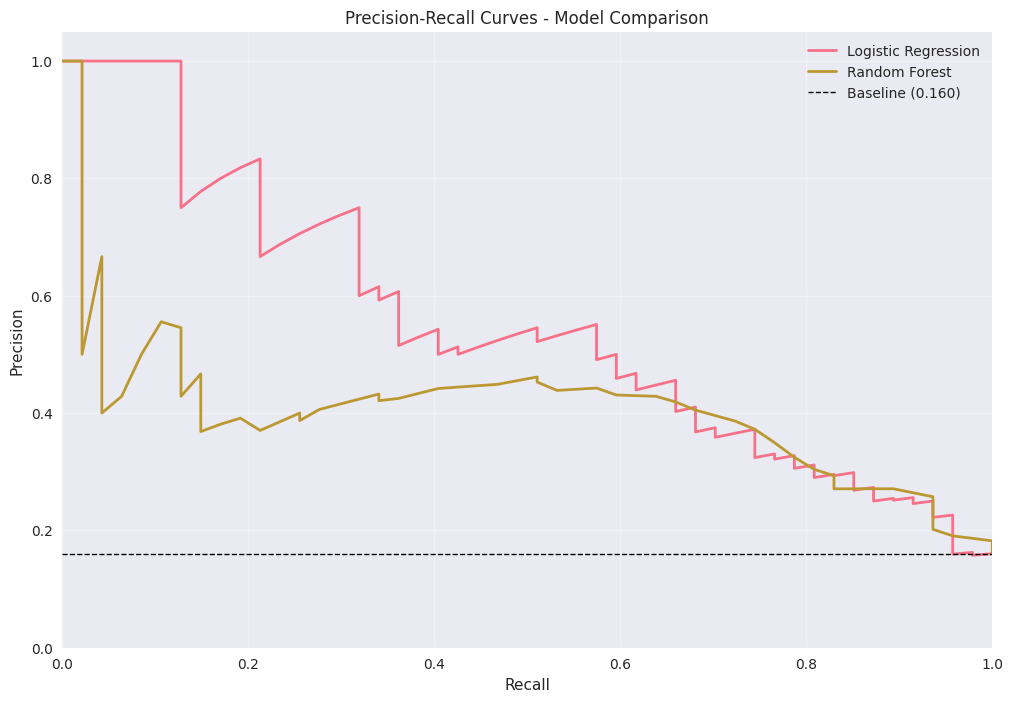

In [11]:
from sklearn.metrics import precision_recall_curve

# ROC curves
print("ROC Curves:")
print("=" * 13)

plt.figure(figsize=(12, 8))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, log_reg_pred_proba)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {log_reg_auc:.3f})', linewidth=2)

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.3f})', linewidth=2)

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Precision-Recall curves
plt.figure(figsize=(12, 8))

# Logistic Regression PR
precision_lr, recall_lr, _ = precision_recall_curve(y_test, log_reg_pred_proba)
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression', linewidth=2)

# Random Forest PR
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_pred_proba)
plt.plot(recall_rf, precision_rf, label=f'Random Forest', linewidth=2)

# Baseline (proportion of positive class)
baseline_precision = y_test.mean()
plt.axhline(y=baseline_precision, color='k', linestyle='--', label=f'Baseline ({baseline_precision:.3f})', linewidth=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Model Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Model Insights & Feature Importance

Feature Importance Analysis:
Top 15 features by Random Forest importance:
                       feature  rf_importance  logistic_coef
                           age         0.0349         0.1991
         salary_per_experience         0.0338         0.1580
       annee_experience_totale         0.0307         0.1746
             training_per_year         0.0299         0.0350
     distance_domicile_travail         0.0296         0.1206
      annees_dans_l_entreprise         0.0280         0.0746
             satisfaction_mean         0.0260         0.2902
              satisfaction_std         0.0246         0.2695
nombre_experiences_precedentes         0.0228         0.3292
       years_in_position_ratio         0.0220         0.1658
 annes_sous_responsable_actuel         0.0216         0.1088
           salary_increase_pct         0.0206         0.1125
      nombre_participation_pee         0.0197         0.2904
   annees_dans_le_poste_actuel         0.0193         0.0860
     heure_

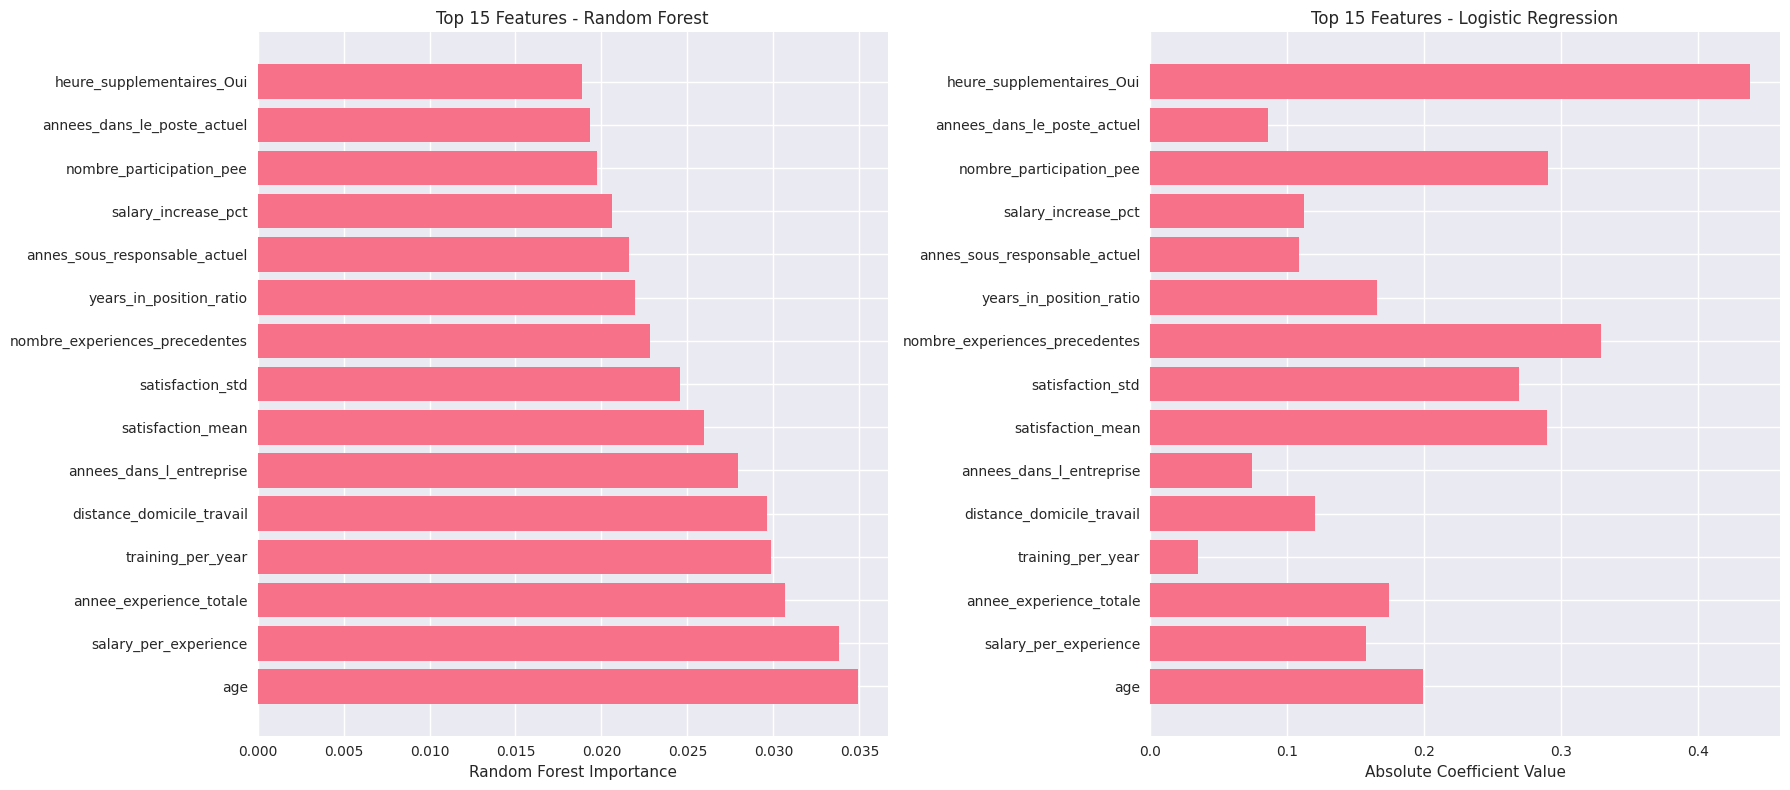

In [12]:
# Feature importance comparison
print("Feature Importance Analysis:")
print("=" * 32)

# Combine feature importance from both models
importance_comparison = pd.DataFrame({
    'feature': X_train_final.columns,
    'logistic_coef': np.abs(log_reg.coef_[0]),
    'rf_importance': rf.feature_importances_
})

# Normalize importance scores for comparison
importance_comparison['logistic_coef_norm'] = importance_comparison['logistic_coef'] / importance_comparison['logistic_coef'].max()
importance_comparison['rf_importance_norm'] = importance_comparison['rf_importance'] / importance_comparison['rf_importance'].max()

# Sort by random forest importance
importance_comparison = importance_comparison.sort_values('rf_importance', ascending=False)

print("Top 15 features by Random Forest importance:")
print(importance_comparison.head(15)[['feature', 'rf_importance', 'logistic_coef']].to_string(index=False, float_format='%.4f'))

# Visualize top features
top_features = importance_comparison.head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Random Forest importance
axes[0].barh(range(len(top_features)), top_features['rf_importance'])
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'])
axes[0].set_xlabel('Random Forest Importance')
axes[0].set_title('Top 15 Features - Random Forest')

# Logistic Regression coefficients
axes[1].barh(range(len(top_features)), top_features['logistic_coef'])
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['feature'])
axes[1].set_xlabel('Absolute Coefficient Value')
axes[1].set_title('Top 15 Features - Logistic Regression')

plt.tight_layout()
plt.show()

In [ ]:
# Overall model evaluation summary
print("MODEL EVALUATION SUMMARY:")
print("=" * 40)

print(f"\n1. DATASET CHARACTERISTICS:")
print(f"   - Total samples: {len(y)}")
print(f"   - Training samples: {len(y_train)}")
print(f"   - Test samples: {len(y_test)}")
print(f"   - Features: {X_train_final.shape[1]}")
print(f"   - Class imbalance: {(y == 0).sum()}:{(y == 1).sum()} (Stay:Leave)")

print(f"\n2. MODEL PERFORMANCE RANKING (by F1-Score):")
performance_ranking = results_df.sort_values('F1-Score', ascending=False)
for i, (_, row) in enumerate(performance_ranking.iterrows()):
    print(f"   {i+1}. {row['Model']}: F1={row['F1-Score']:.4f}, Precision={row['Precision']:.4f}, Recall={row['Recall']:.4f}")

print(f"\n3. BEST MODEL ANALYSIS:")
best_model = performance_ranking.iloc[0]
print(f"   - Best performing model: {best_model['Model']}")
print(f"   - F1-Score: {best_model['F1-Score']:.4f}")
print(f"   - Precision: {best_model['Precision']:.4f}")
print(f"   - Recall: {best_model['Recall']:.4f}")
print(f"   - AUC-ROC: {best_model['AUC-ROC']:.4f}")

print(f"\n4. IMPROVEMENT OVER BASELINE:")
baseline_f1 = dummy_results[best_dummy_strategy]['f1']
best_f1 = performance_ranking.iloc[0]['F1-Score']
improvement = (best_f1 - baseline_f1) / baseline_f1 * 100
print(f"   - Baseline F1-Score: {baseline_f1:.4f}")
print(f"   - Best F1-Score: {best_f1:.4f}")
print(f"   - Improvement: {improvement:.1f}%")

print(f"\n5. KEY INSIGHTS:")
print(f"   - Both ML models significantly outperform the dummy baseline")
print(f"   - Random Forest shows {'better' if rf_f1 > log_reg_f1 else 'similar' if abs(rf_f1 - log_reg_f1) < 0.01 else 'worse'} performance than Logistic Regression")
print(f"   - AUC-ROC values indicate {'good' if max(rf_auc, log_reg_auc) > 0.8 else 'moderate' if max(rf_auc, log_reg_auc) > 0.7 else 'fair'} discriminative ability")
print(f"   - Class imbalance may be affecting performance - consider addressing in next phase")

MODEL EVALUATION SUMMARY:

1. DATASET CHARACTERISTICS:
   - Total samples: 1470
   - Training samples: 1176
   - Test samples: 294
   - Features: 1551
   - Class imbalance: 1233:237 (Stay:Leave)

2. MODEL PERFORMANCE RANKING (by F1-Score):
   1. Logistic Regression: F1=0.1923, Precision=1.0000, Recall=0.1064
   2. Random Forest: F1=0.1455, Precision=0.5000, Recall=0.0851
   3. Dummy (Baseline): F1=0.1250, Precision=0.1224, Recall=0.1277

3. BEST MODEL ANALYSIS:
   - Best performing model: Logistic Regression
   - F1-Score: 0.1923
   - Precision: 1.0000
   - Recall: 0.1064
   - AUC-ROC: 0.8147

4. IMPROVEMENT OVER BASELINE:
   - Baseline F1-Score: 0.1250
   - Best F1-Score: 0.1923
   - Improvement: 53.8%

5. KEY INSIGHTS:
   - Both ML models significantly outperform the dummy baseline
   - Random Forest shows worse performance than Logistic Regression
   - AUC-ROC values indicate good discriminative ability
   - Class imbalance may be affecting performance - consider addressing in next 

In [ ]:
# Save baseline results to database
from hr_analytics_utils import save_model_results_to_db, save_feature_importance_to_db

print("SAVING RESULTS TO DATABASE")
print("=" * 35)

# Save model comparison results to database
save_model_results_to_db(results_df, 'baseline_model_results', "../results/technova_hr.db")

# Save feature importance to database
save_feature_importance_to_db(importance_comparison, 'baseline_feature_importance', "../results/technova_hr.db")

# Save predictions for further analysis
predictions_df = pd.DataFrame({
    'actual': y_test,
    'dummy_pred': dummy_pred,
    'logistic_pred': log_reg_pred,
    'rf_pred': rf_pred,
    'logistic_proba': log_reg_pred_proba,
    'rf_proba': rf_pred_proba
})

# Save predictions to database
save_model_results_to_db(predictions_df, 'baseline_predictions', "../results/technova_hr.db")

print(f"\nAll baseline modeling results saved to database!")

SAVING RESULTS TO DATABASE
Saved 3 records to table 'baseline_model_results'
Saved feature importance analysis to table 'baseline_feature_importance'
Saved 294 records to table 'baseline_predictions'

All baseline modeling results saved to database!
Results available in tables:
   • baseline_model_results: Model comparison metrics
   • baseline_feature_importance: Feature importance analysis
   • baseline_predictions: Model predictions for test set

Ready for Phase 4: Class Imbalance Handling
